In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Activation, Input, Embedding, Reshape, MaxPooling1D, Conv1D
from keras.layers import LSTM, GRU, Conv1D
from keras.layers import Dropout, BatchNormalization, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.activations import sigmoid
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.callbacks import TensorBoard
import numpy as np
import random
import sys
import os

In [2]:
import re

from libs.utils import text_preprocess
from libs.text_utils import split_raw_into_sentences

In [3]:
with open('data/checkov/input.txt', encoding='utf-8') as f:
    dostoewskij_text = f.read().lower()
with open('data/checkov/non_checkov_texts.txt', encoding='utf-8') as f:
    non_dostoewskij_text = f.read().lower()

sentenced_dostoewskij = split_raw_into_sentences(dostoewskij_text)
sentenced_non_dostoewskij = split_raw_into_sentences(non_dostoewskij_text)

sentenced_dostoewskij = text_preprocess(sentenced_dostoewskij)
sentenced_non_dostoewskij = text_preprocess(sentenced_non_dostoewskij)

dostoewskij_sentences = sentenced_dostoewskij.split('\n')
non_dostoewskij_sentences = sentenced_non_dostoewskij.split('\n')

#dostoewskij_text = clear_text_from_rare_chars(dostoewskij_text, delete_enters=True)
#non_dostoewskij_text = clear_text_from_rare_chars(non_dostoewskij_text, delete_enters=True)

print('dostoewskij_length:\t', len(dostoewskij_text))
print('non_dostoewskij_length:\t', len(non_dostoewskij_text))

dostoewskij_length:	 11145098
non_dostoewskij_length:	 179545637


In [4]:
s = set(sentenced_dostoewskij)
print(len(s))
s2 = set(sentenced_non_dostoewskij)
print(len(s2))

39
39


In [5]:
from libs.utils import load_transformer

transformer = load_transformer('models/shm_c1')

chars = transformer.tokens
char_cats = len(chars)
print('total chars:', char_cats)

total chars: 42


In [6]:
print_len = 2000
pos = np.random.randint(len(dostoewskij_text))
print(dostoewskij_text[pos:pos+print_len])
print('-' * 100)
pos = np.random.randint(len(non_dostoewskij_text))
print(non_dostoewskij_text[pos:pos+print_len])

секретарь и дьячок вышли из кабинета и были уже на улице, а он вс еще топал ногами и кричал: аставьте меня в покое!
что вам нужно от меня, не понимаю?
ааставьте меня в покое!
примечания. неизвестный лат. первый любовник франц.
глава.
была полночь.
природа капризничала, как старая дева.
месяц зарылся в черные тучи и не глядел на землю.
осенний дождь с остервенением стучал в окна...
гнулись дубы и ломались сосны.
ветер стонал, как озлобленный, и рвал вс и вся...
стонущие и воющие от ветра телеграфные проволоки несли из таганрога в скопин следующую телеграмму: скопин.
кавалеру ордена льва и солнца рыкову.
вс погибло.
он донес.
я заключен в темницу.
в таможне аресты.
ужасно!
напрасно узембло не уступил ему этой женщины.
ответ не уплочен.
м. вальяно.
прочитав эту телеграмму, рыков побледнел, но пошагав немного, он улыбнулся.
лицо его прояснилось.
он позвонил...
вошел слуга.
свентицкий еще не уехал? спросил рыков.
никак нетс!
позвать его!
минут через десять в кабинет рыкова вошел высокий ста

In [7]:
n_batches = len(dostoewskij_text) // 3000
batch_size = 16
#n_batches -= n_batches % batch_size
max_len = 200

In [8]:
from libs.utils import pad

# transform text into sequence of indices
pad_idx = char_cats
dostoewskij_indexes     = np.array([pad(transformer.transform(sent), max_len, pad_idx) for sent in dostoewskij_sentences])
non_dostoewskij_indexes = np.array([pad(transformer.transform(sent), max_len, pad_idx) for sent in non_dostoewskij_sentences])

In [9]:
from libs.utils import split_data_into_correct_batches
X, y = split_data_into_correct_batches(dostoewskij_indexes, non_dostoewskij_indexes, 
                                       n_batches, max_len, make_equal_folding=True)

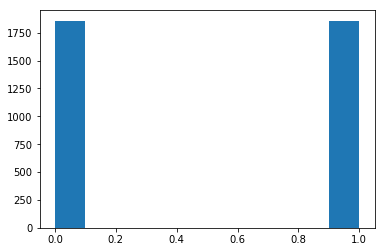

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

a = plt.hist(y)

In [11]:
from keras.losses import sparse_categorical_crossentropy

In [12]:
def create_char_rnn():
    inp = Input(shape=(max_len,), dtype="int32")
    v = Embedding(char_cats, int(char_cats / 1.5))(inp)
    h1 = GRU(256, stateful=False, return_sequences=True, unroll=True, implementation=0)(v)
    h2 = GRU(256, stateful=False, return_sequences=False, unroll=True, implementation=0)(h1)
    y = Dense(2, activation='softmax')(h2)
    model = Model(inp, y, name="char_rnn")
    model.compile(optimizer=RMSprop(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
    return model

In [13]:
def create_cnn():
    inp = Input(shape=(max_len,), dtype="int32")
    v = Embedding(char_cats+1, int(char_cats / 1.5))(inp)
    x = Conv1D(128, kernel_size=8, activation='relu', padding='same')(v) # None, 200, 64
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(4, padding='same')(x) # None, 50, 64

    x = Conv1D(128, kernel_size=8, activation='relu', padding='same')(x) # None, 50, 128
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(2, padding='same')(x) # None, 25, 128

    x = Conv1D(256, kernel_size=8, activation='relu', padding='same')(x) # None, 25, 256
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(5, padding='same')(x) # None, 5, 256

    h = Flatten()(x) # None, 5*256
    y = Dense(2, activation='softmax')(h) # None, 512
    model = Model(inp, y, name="char_cnn")
    model.compile(optimizer=RMSprop(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
    return model

In [14]:
rnn = create_cnn()

In [15]:
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 28)           1204      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          28800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           131200    
__________

In [16]:
history = rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1)#, callbacks=[tb])

Epoch 1/1
3715/3715 [==============================] - 10s - loss: 0.1101 - acc: 0.9865    


In [18]:
n_epochs = 8
histories = []
for epoch in range(n_epochs):
    X, y = split_data_into_correct_batches(dostoewskij_indexes, non_dostoewskij_indexes, n_batches, max_len, make_equal_folding=True)
    histories.append(rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1))

Epoch 1/1
3715/3715 [==============================] - 3s - loss: 0.0037 - acc: 0.9992     
Epoch 1/1
3715/3715 [==============================] - 3s - loss: 2.1587e-06 - acc: 1.0000     
Epoch 1/1
1232/3715 [========>.....................] - ETA: 2s - loss: 1.1921e-07 - acc: 1.0000

KeyboardInterrupt: 

In [ ]:
rnn.save('models/discriminator_style_rnn_model.h5')